In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
import os


In [4]:
filepaths = []
labels = []
osteo_dir = r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis'
normal_dir = r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal'

for d in [osteo_dir, normal_dir]:
    flist=os.listdir(d)

    for f in flist:
        fpath=os.path.join(d,f)
        filepaths.append(fpath)

        if d == osteo_dir:
            labels.append('Osteoporosis')
        else:
            labels.append('Normal')

print ('Total number of images: ', len(labels))

Total number of images:  372


# Add files to dataframe

In [5]:
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')

In [6]:
df = pd.concat([Fseries, Lseries], axis=1)
df.head()

,filepaths,labels
0,/kaggle/input/osteoporosis-knee-xray-dataset/o...,Osteoporosis
1,/kaggle/input/osteoporosis-knee-xray-dataset/o...,Osteoporosis
2,/kaggle/input/osteoporosis-knee-xray-dataset/o...,Osteoporosis
3,/kaggle/input/osteoporosis-knee-xray-dataset/o...,Osteoporosis
4,/kaggle/input/osteoporosis-knee-xray-dataset/o...,Osteoporosis


In [7]:
df['labels'].value_counts()

Osteoporosis    186
Normal          186
Name: labels, dtype: int64

Class distribution is equal

# Feature Selection

In [8]:
height=200
width=400
channels=3
batch_size=16
img_shape=(height, width, channels)
img_size=(height, width)
train_split=.8
test_split=0.06

In [9]:
dummy_split = test_split/(1-train_split)
train_df, dummy_df = train_test_split(df, train_size = train_split, shuffle = True, random_state = 123)
test_df, valid_df = train_test_split(dummy_df, 
                                     train_size = dummy_split, 
                                     shuffle = True, 
                                     random_state = 123)
print ('train samples: ', len(train_df), '  test samples: ', len(test_df), ' validation samples', len(valid_df))

train samples:  297   test samples:  22  validation samples 53


In [10]:
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]

test_steps = int(length/test_batch_size)
print ('test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

test batch size:  22   test steps:  1


Data Augmentation.
-----


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_gen = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size)

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=test_batch_size)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen = valid_datagen.flow_from_dataframe(
    valid_df, 
    x_col='filepaths', 
    y_col='labels', 
    target_size=img_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=False, 
    batch_size=batch_size)

Found 297 validated image filenames belonging to 2 classes.
Found 22 validated image filenames belonging to 2 classes.
Found 53 validated image filenames belonging to 2 classes.


In [12]:
classes = list(train_gen.class_indices.keys())
class_count = len(classes)
train_steps = int(len(train_gen.labels)/batch_size)

# EDA

In [13]:
def show_image_samples(gen, class_names):
    class_dict = gen.class_indices
    new_dict = {}
    
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value] = key        
        
    images, labels = next(gen) # get a sample batch from the generator   
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = 15
    
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = class_names[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

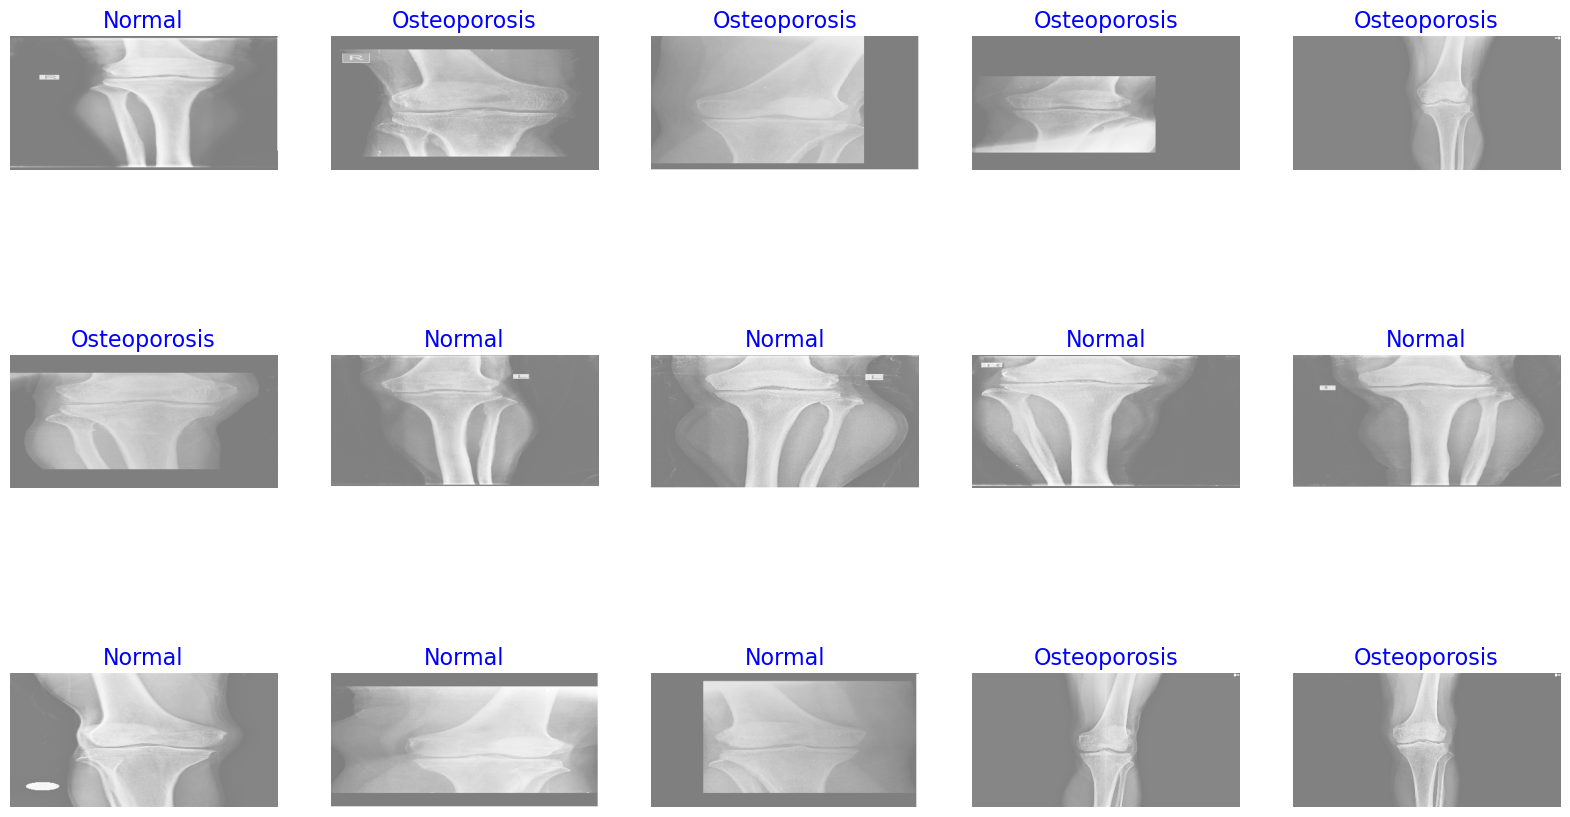

In [14]:
show_image_samples(test_gen, classes)

# Base

In [15]:
# Define the model
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=img_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(class_count, activation='sigmoid')
])

In [16]:
# Compile the model
model.compile(
    optimizer = Adam(),  # Use the Adam optimizer
    loss = "binary_crossentropy",  # Use categorical cross-entropy loss for multi-class classification
    metrics = ["accuracy"]  # Monitor the accuracy during training
)

In [17]:
# Train the model
history = model.fit(
    train_gen,  # Pass your training data
    validation_data = valid_gen,
    epochs=10,  # Set the number of epochs to train for
)

Epoch 1/10
19/19 [==============================] - 32s 1s/step - loss: 0.8027 - accuracy: 0.5286 - val_loss: 0.6908 - val_accuracy: 0.3962
Epoch 2/10
19/19 [==============================] - 18s 941ms/step - loss: 0.6886 - accuracy: 0.5522 - val_loss: 0.6706 - val_accuracy: 0.6792
Epoch 3/10
19/19 [==============================] - 17s 892ms/step - loss: 0.6824 - accuracy: 0.5758 - val_loss: 0.6475 - val_accuracy: 0.6604
Epoch 4/10
19/19 [==============================] - 18s 941ms/step - loss: 0.6784 - accuracy: 0.5623 - val_loss: 0.6389 - val_accuracy: 0.7170
Epoch 5/10
19/19 [==============================] - 17s 921ms/step - loss: 0.6741 - accuracy: 0.5859 - val_loss: 0.6685 - val_accuracy: 0.6415
Epoch 6/10
19/19 [==============================] - 18s 923ms/step - loss: 0.6682 - accuracy: 0.6128 - val_loss: 0.6521 - val_accuracy: 0.6981
Epoch 7/10
19/19 [==============================] - 17s 901ms/step - loss: 0.6648 - accuracy: 0.5960 - val_loss: 0.6557 - val_accuracy: 0.6981
Ep

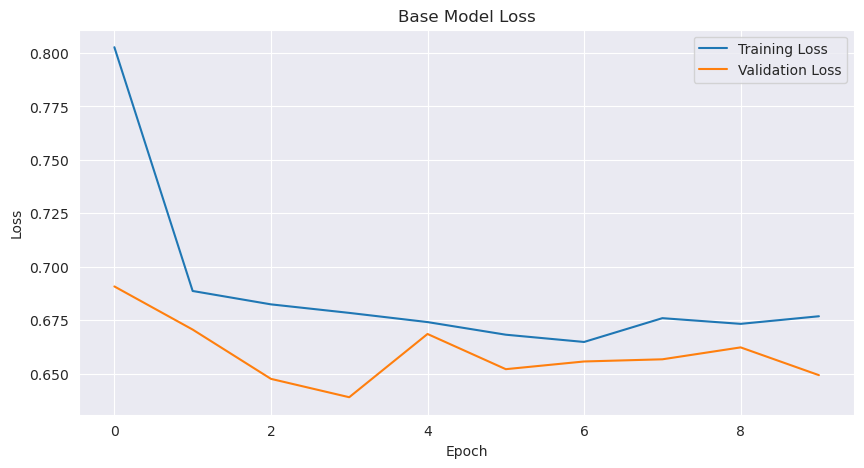

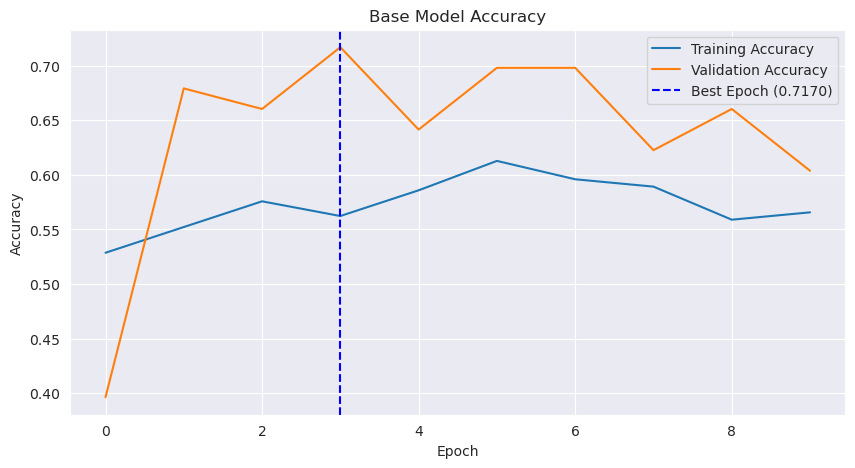

In [18]:
# Extract training and validation loss and accuracy from history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Find the index of the epoch with the best validation accuracy
best_epoch = val_acc.index(max(val_acc))

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Base Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Base Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Highlight the overall best epoch
best_val_acc = max(val_acc)
plt.axvline(x=val_acc.index(best_val_acc), color='blue', linestyle='--', label=f'Best Epoch ({best_val_acc:.4f})')

plt.legend()
plt.show()

# Evaluate

In [19]:
y_pred = model.predict(test_gen, steps=test_steps).argmax(axis=1)
y_true = test_gen.classes

weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Print the results
print('Weighted F1 score of both classes:', weighted_f1_score)
print('Accuracy of the model:', accuracy)

1/1 [==============================] - 1s 1s/step
Weighted F1 score of both classes: 0.5376845376845376
Accuracy of the model: 0.5454545454545454


In [20]:
report = classification_report(y_true, y_pred)
print("Classification Report:\n----------------------\n", report)

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.50      0.40      0.44        10

    accuracy                           0.55        22
   macro avg       0.54      0.53      0.53        22
weighted avg       0.54      0.55      0.54        22



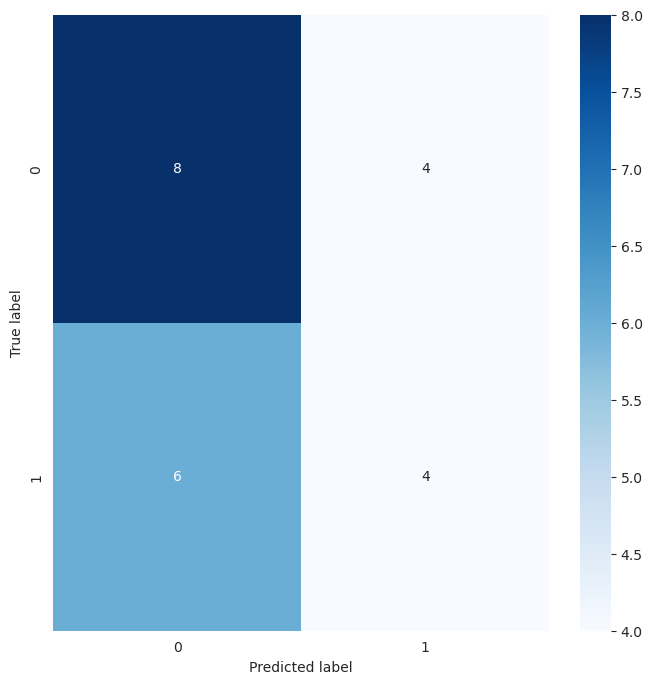

In [21]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Transfer Learning Model

In [22]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D

# Define the path to the InceptionResNetV2 weights file in Kaggle environment
weights_path = '/kaggle/input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'  # Change this path accordingly

# Load the pre-trained InceptionResNetV2 model with the custom weights
incept_resnet_model = keras.applications.InceptionResNetV2(
    weights=weights_path,  # Load weights from the provided path
    input_shape=img_shape,  # Set input shape to match your dataset
    include_top=False  # Don't include the fully connected layer at the top of the network
)

# The rest of the code remains unchanged...


# Freeze the base model layers to prevent them from being updated during training
incept_resnet_model.trainable = False

inputs = keras.Input(shape=img_shape)
x = incept_resnet_model(inputs, training=False)
x = GlobalAveragePooling2D()(x) 
# Convert features to a single vector by averaging across spatial dimensions
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)  # Add a dense layer with ReLU activation
x = Dropout(0.1)(x)

# Add BatchNormalization layer for better training stability
x = BatchNormalization()(x)

x = Dense(256, activation="relu")(x)

# Add Dropout layer to reduce overfitting
x = Dropout(0.1)(x)

# Add BatchNormalization layer for better training stability
x = BatchNormalization()(x)

# Add another Dense layer
x = Dense(128, activation="relu")(x)

# Add Dropout layer to reduce overfitting
x = Dropout(0.1)(x)

# Add BatchNormalization layer for better training stability
x = BatchNormalization()(x)


outputs = Dense(class_count, activation="softmax")(x)  # Add a dense layer with sigmoid activation for classification

 # Add a dense layer with softmax activation for classification

# Create the final model
model = keras.Model(inputs, outputs)




In [23]:
# Compile the model
model.compile(
    optimizer= Adamax(),  # Use the Adam optimizer
    loss="binary_crossentropy",  # Use categorical cross-entropy loss for multi-class classification
    metrics=["accuracy"]  # Monitor the accuracy during training
)

In [24]:
# Train the model
history = model.fit(
    train_gen,  # Pass your training data
    validation_data = valid_gen,
    epochs=20,  # Set the number of epochs to train for
)

Epoch 1/20
19/19 [==============================] - 40s 1s/step - loss: 0.7554 - accuracy: 0.6364 - val_loss: 0.6259 - val_accuracy: 0.7547
Epoch 2/20
19/19 [==============================] - 19s 1s/step - loss: 0.6028 - accuracy: 0.7205 - val_loss: 0.5716 - val_accuracy: 0.7736
Epoch 3/20
19/19 [==============================] - 18s 947ms/step - loss: 0.5814 - accuracy: 0.7239 - val_loss: 0.5475 - val_accuracy: 0.7547
Epoch 4/20
19/19 [==============================] - 19s 980ms/step - loss: 0.5890 - accuracy: 0.7508 - val_loss: 0.5233 - val_accuracy: 0.8113
Epoch 5/20
19/19 [==============================] - 18s 934ms/step - loss: 0.5308 - accuracy: 0.7542 - val_loss: 0.5128 - val_accuracy: 0.8113
Epoch 6/20
19/19 [==============================] - 18s 954ms/step - loss: 0.5207 - accuracy: 0.7946 - val_loss: 0.5363 - val_accuracy: 0.7547
Epoch 7/20
19/19 [==============================] - 17s 914ms/step - loss: 0.5469 - accuracy: 0.7744 - val_loss: 0.5191 - val_accuracy: 0.7358
Epoch

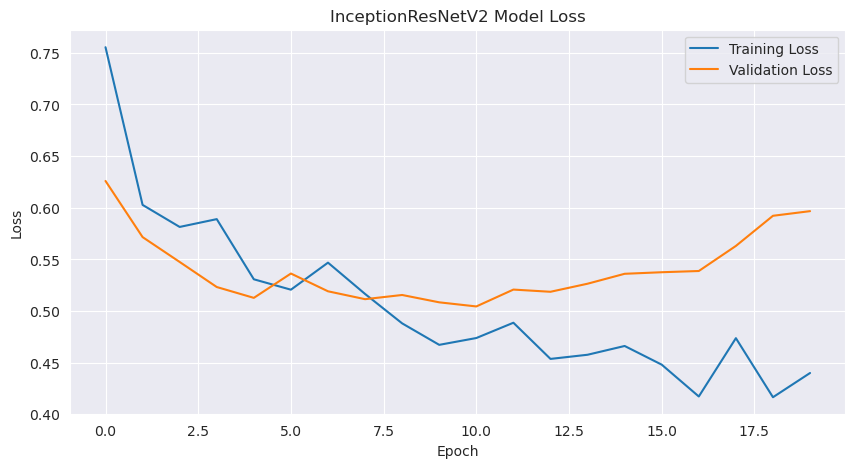

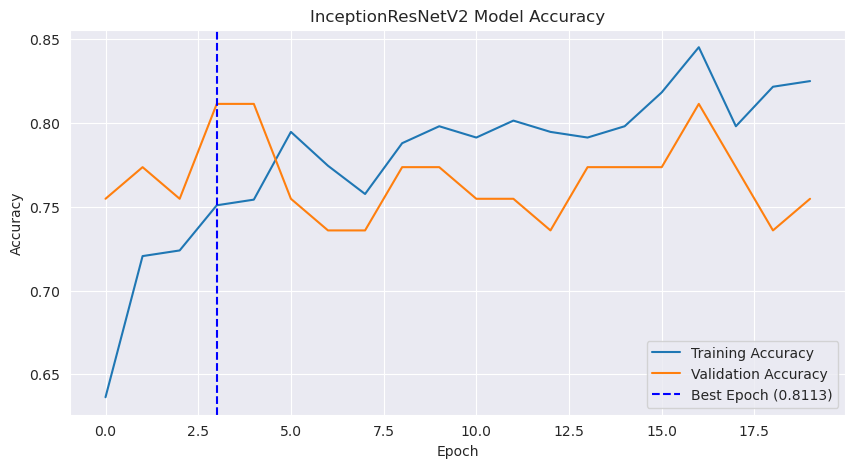

In [25]:
# Extract training and validation loss and accuracy from history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Find the index of the epoch with the best validation accuracy
best_epoch = val_acc.index(max(val_acc))

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('InceptionResNetV2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('InceptionResNetV2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Highlight the overall best epoch
best_val_acc = max(val_acc)
plt.axvline(x=val_acc.index(best_val_acc), color='blue', linestyle='--', label=f'Best Epoch ({best_val_acc:.4f})')

plt.legend()
plt.show()

 #  Evaluate

In [26]:
y_pred = model.predict(test_gen, steps=test_steps).argmax(axis=1)
y_true = test_gen.classes

weighted_f1_score = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)



1/1 [==============================] - 5s 5s/step


In [27]:
report = classification_report(y_true, y_pred)
print("Classification Report:\n----------------------\n", report)

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.70      0.70      0.70        10

    accuracy                           0.73        22
   macro avg       0.72      0.72      0.72        22
weighted avg       0.73      0.73      0.73        22



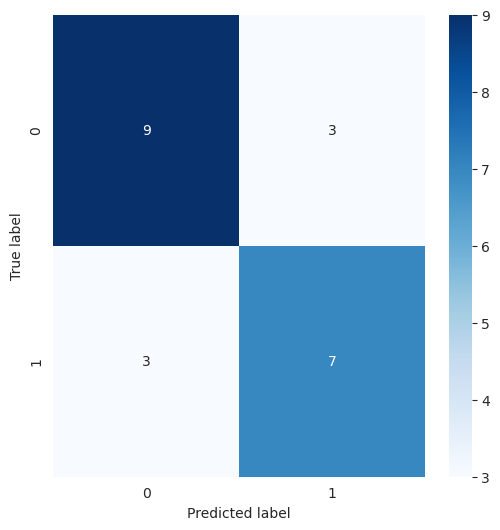

In [28]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

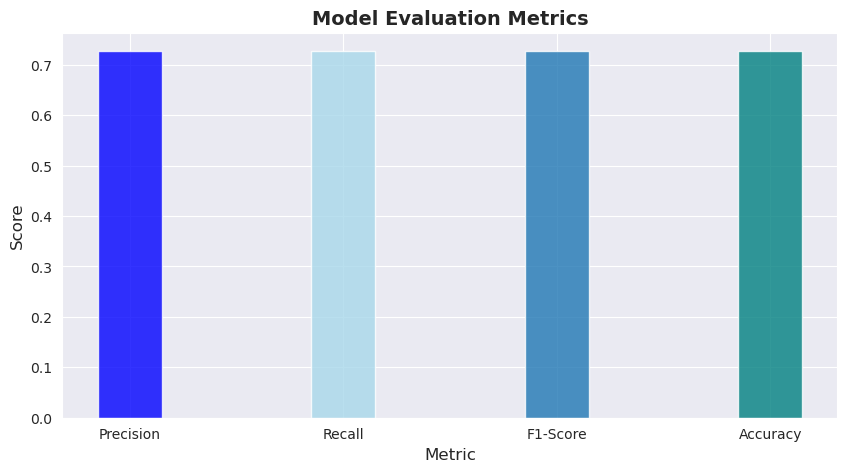

In [39]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot bar graph for metrics
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

values = [precision, recall, f1, accuracy]

plt.figure(figsize=(10, 5))
colors=['blue', '#a8d8ea', '#1f77b4', '#008080']
plt.title('Classification Metrics')
plt.ylabel('Score')
bar_width = 0.3
bar_alpha = 0.8

plt.bar(metrics, values, color=colors, width=bar_width, alpha=bar_alpha)
plt.title('Model Evaluation Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 400, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 4, 11, 1536)      54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 batch_normalization_203 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                             